# Continuous Control


### Imports

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline

### The Agent

In [2]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay

N_LEARN_UPDATES = 10     # number of learning updates
N_TIME_STEPS = 20       # every n time step do update

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    memory = None
    actor_local = None
    actor_target = None
    actor_optimizer = None

    critic_local = None
    critic_target = None
    critic_optimizer = None

    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network
        if Agent.actor_local is None:
            Agent.actor_local = Actor(state_size, action_size, random_seed).to(device)
        if Agent.actor_target is None:
            Agent.actor_target = Actor(state_size, action_size, random_seed).to(device)
        if Agent.actor_optimizer is None:
            Agent.actor_optimizer = optim.Adam(Agent.actor_local.parameters(), lr=LR_ACTOR)
        self.actor_local = Agent.actor_local
        self.actor_target = Agent.actor_target
        self.actor_optimizer = Agent.actor_optimizer

        # Critic Network
        if Agent.critic_local is None:
            Agent.critic_local = Critic(state_size, action_size, random_seed).to(device)
        if Agent.critic_target is None:
            Agent.critic_target = Critic(state_size, action_size, random_seed).to(device)
        if Agent.critic_optimizer is None:
            Agent.critic_optimizer = optim.Adam(Agent.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.critic_local = Agent.critic_local
        self.critic_target = Agent.critic_target
        self.critic_optimizer = Agent.critic_optimizer

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        if Agent.memory is None:
            print("Initialising ReplayBuffer")
            Agent.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, time_step, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        Agent.memory.add(state, action, reward, next_state, done)

        # only learn every n_time_steps
        if time_step % N_TIME_STEPS != 0:
            return

        # Learn, if enough samples are available in memory
        if len(Agent.memory) > BATCH_SIZE:
            for i in range(N_LEARN_UPDATES):
                experiences = Agent.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### The Model

In [3]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)


### The Training Function

In [4]:
def ddpg(n_episodes=300, max_t=1000):
    """ Deep Deterministic Policy Gradients
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores_window = deque(maxlen=100)
    scores = np.zeros(num_agents)
    scores_episode = []
    
    agents =[] 
    
    for i in range(num_agents):
        agents.append(Agent(state_size, action_size, random_seed=0))
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        for agent in agents:
            agent.reset()
            
        scores = np.zeros(num_agents)
            
        for t in range(max_t):
            actions = np.array([agents[i].act(states[i]) for i in range(num_agents)])

            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done        
            
            for i in range(num_agents):
                agents[i].step(t,states[i], actions[i], rewards[i], next_states[i], dones[i]) 
 
            states = next_states
            scores += rewards
            if t % 20:
                print('\rTimestep {}\tScore: {:.2f}\tmin: {:.2f}\tmax: {:.2f}'
                      .format(t, np.mean(scores), np.min(scores), np.max(scores)), end="") 
            if np.any(dones):
                break 
        score = np.mean(scores)
        scores_window.append(score)       # save most recent score
        scores_episode.append(score)

        print('\rEpisode: {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end="\n")
        if i_episode % 100 == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes.\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(Agent.actor_local.state_dict(), 'saved_model_actor.pth')
            torch.save(Agent.critic_local.state_dict(), 'saved_model_critic.pth')
            break
            
    return scores_episode

### Startup

In [5]:
env = UnityEnvironment(file_name='.\Reacher_Windows_x86_64\Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Train the agent with ddpg

Episode: 1	Score: 6.34	Average Score: 6.34.73
Episode: 2	Score: 8.58	Average Score: 7.46.33
Episode: 3	Score: 9.08	Average Score: 8.00.40
Episode: 4	Score: 8.65	Average Score: 8.16.69
Episode: 5	Score: 9.64	Average Score: 8.46.63
Episode: 6	Score: 10.06	Average Score: 8.73.75
Episode: 7	Score: 11.72	Average Score: 9.15.35
Episode: 8	Score: 10.00	Average Score: 9.26.61
Episode: 9	Score: 12.74	Average Score: 9.65.87
Episode: 10	Score: 11.27	Average Score: 9.8115
Episode: 11	Score: 12.91	Average Score: 10.097
Episode: 12	Score: 11.59	Average Score: 10.226
Episode: 13	Score: 11.40	Average Score: 10.319
Episode: 14	Score: 11.36	Average Score: 10.381
Episode: 15	Score: 11.88	Average Score: 10.482
Episode: 16	Score: 11.81	Average Score: 10.566
Episode: 17	Score: 11.90	Average Score: 10.645
Episode: 18	Score: 11.81	Average Score: 10.714
Episode: 19	Score: 11.70	Average Score: 10.769
Episode: 20	Score: 11.93	Average Score: 10.822
Episode: 21	Score: 12.76	Average Score: 10.913
Episode: 22	Score:

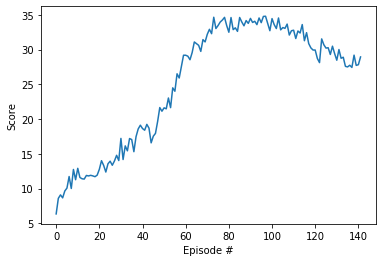

In [10]:
scores = ddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
env.close()